In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data -->

In [2]:
hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

# hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

# hit_data_1056 = rf.get_ROOT_data_zip("TB_FIRE_1056_hits.root")

# hit_data_1057 = rf.get_ROOT_data_zip("TB_FIRE_1057_hits.root")

# hit_data_1079 = rf.get_ROOT_data_zip("TB_FIRE_1079_hits.root")

TB_FIRE_1101_hits.root finished


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes -->

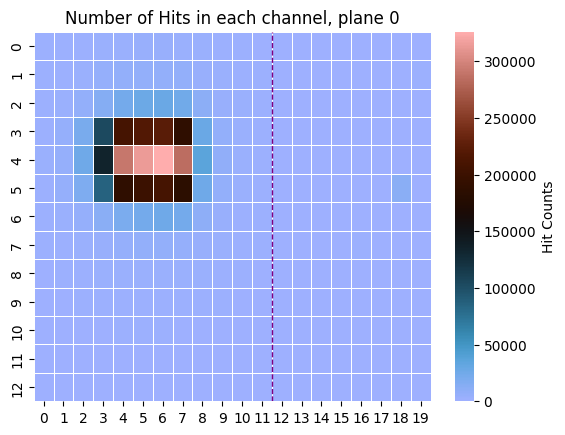

In [66]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 0, cmap="berlin")

In [ ]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 7, cmap="managua")

In [6]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 0, cmap="managua")

In [7]:
# rf.single_event_evolution_amp(hit_data_1101, 54106, cmap="managua")

In [8]:
# plt.clf()   # Clear the current figure
# plt.close() # Close any open figures
# %matplotlib widget
# rf.amp_histo_single_plane(hit_data_1101,1)

In [9]:
# rf.average_amp_vs_plane(hit_data_1101)

In [10]:
# # shower initial starting points
# rf.plot_empty_first_planes(hit_data_1101)

In [3]:
# rf.event_shower_energy_vs_X_position(hit_data_1101, single_pad_only="true")

In [12]:
# returns histogram of the amount of hits with the same energy in given X position
def shower_energy_histo_single_location(hit_data, Position):

    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data_1101[hit_data_1101.plane == 7]
    mask = ak.num(plane_7) > 0
    first_plane_starting_events = hit_data_1101[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    print("avg ok")
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)
    print("shower per event ok")
    # get the shower energy for the X position for all events
    amps_divided_by_class, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    print("groupby ok")
    # div, avg_amps, classes = ak_groupby(x_avg, event_shower_amp_array)

    amps_class_position = amps_divided_by_class[amps_divided_by_class.classes == Position]
    print("amps class at position ok")
    amps_position = amps_class_position.data
    print("amp position ok")
    amps_position_clean = amps_position[ak.num(amps_position) > 0]
    print("amp position clean ok")




    # Plot
    plt.hist(amps_position_clean[0], bins=100, range=(0,500))
    plt.show()



In [13]:
# shower_energy_histo_single_location(hit_data_1101,5)


In [4]:
rf.initial_X_position_DUT(hit_data_1101, return_y = "true")
# rf.initial_X_position_DUT(hit_data_1101)

(<Array [4, 6, 4, 3, 5.5, 5, ..., 5, 3, 5, 7, 5.5, 4.5] type='2154539 * float64'>,
 <Array [8, 9, 8.5, 8, 7.5, 7, ..., 7, 8, 7, 8, 8, 8.5] type='2154539 * float64'>)

In [9]:
# rf.avg_hit_amount_vs_plane_per_X_position(hit_data_1101,6)

In [ ]:
# Histogram of ENERGies in all showers starting at a certain position
  
def Histo_shower_energy_for_X_position(hit_data, number_of_highest_ocupied_columns, single_pad_only = "false"):
    
    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data[hit_data.plane == 7]
    if single_pad_only == "false":
        mask = ak.num(plane_7) > 0

    if single_pad_only == "true":
        mask = ak.num(plane_7) == 1

    first_plane_starting_events = hit_data[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)

    # get the average shower energy for each X position
    div, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)

    # get the most ocupied columns
    top_columns = rf.columns_with_max_hits(hit_data, number_of_highest_ocupied_columns)
    top_columns = np.sort(top_columns)
    
    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of energy per position
    for column in top_columns:
        Column_data = div[div.classes == column]
        energies_in_column = ak.flatten(Column_data[ak.num(Column_data) > 0].data) #get only the amplitudes of the needed column
        print(column, len(energies_in_column))
        print("########")
        ax1.hist(energies_in_column, bins=200, histtype='step', label= f'Column: {column}')
        # plt.hist(energies_in_column, bins=200, histtype='step', label= f'Column: {column}')
    

        
    
    # ax1.set_xticks(np.arange(0, 20))
    ax1.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
    ax1.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    ax1.legend()
    ax1.set_xlabel('X Position at Shower Initiation [Pad Column]')
    ax1.set_ylabel('AVG Shower Energy')
    ax1.set_title('Average Shower Energy vs Initial Location')

    # show the amounnt of hits in each plane on a bar chart
    bins = np.arange(0, 21, 1) 
    ax2.hist(x_avg, bins=bins, edgecolor='black', rwidth=0.8)
    ax2.set_xticks(np.arange(0, 20) + 0.5)  # shift by 0.5
    ax2.set_xticklabels(np.arange(0, 20)) 
    ax2.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
    ax2.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    ax2.set_xlabel('X Position [Pad Column]')
    ax2.set_ylabel('amount of hits')
    ax2.set_title('Amount of Events initiating in Each Column of the Sensor')
    
    plt.show()






2 47115
########
3 174813
########
4 524937
########
5 387197
########
6 560763
########
7 351098
########


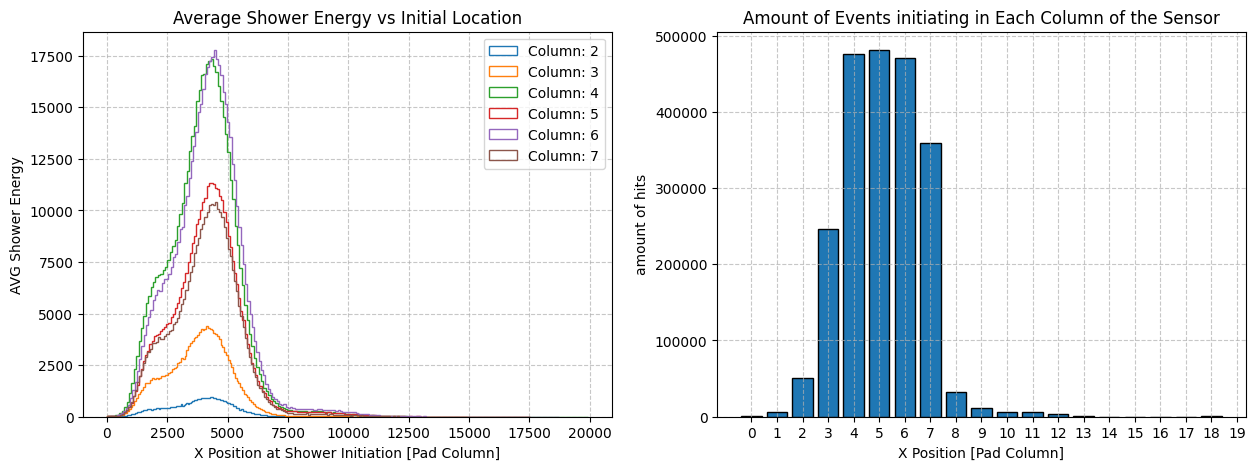

In [111]:
a = Histo_shower_energy_for_X_position(hit_data_1101, 6, single_pad_only = "false")

In [82]:
b = a[a.classes == 1]

In [89]:
ak.flatten(b[ak.num(b) > 0].data)

<Array [2541, 4637, 737, 3147, ..., 1528, 4972, 4632, 3241] type='2849 * int64'>

[2 3 4 5 6 7]
2
[np.float64(174.65315760354093), np.float64(370.41231876606685), np.float64(527.0704580784527), np.float64(683.5640948058498), np.float64(758.3661927823778), np.float64(697.0929319893223), np.float64(753.4592523103331), np.float64(646.7843995622326)]
3
[np.float64(152.87567850661557), np.float64(364.6767163018019), np.float64(511.71106433156456), np.float64(680.3788072011793), np.float64(766.672646034562), np.float64(705.6655264996874), np.float64(770.0585550926191), np.float64(669.5447981648011)]
4
[np.float64(145.05329669522285), np.float64(371.7221684097543), np.float64(475.2987042529361), np.float64(699.4425033336829), np.float64(785.028796830825), np.float64(792.1053898131203), np.float64(782.4767374962456), np.float64(690.1910175518376)]
5
[np.float64(153.82507677816568), np.float64(393.67737952072906), np.float64(560.4077246953284), np.float64(718.0207013723239), np.float64(774.7246425795113), np.float64(835.2951788348468), np.float64(759.8003566145504), np.float

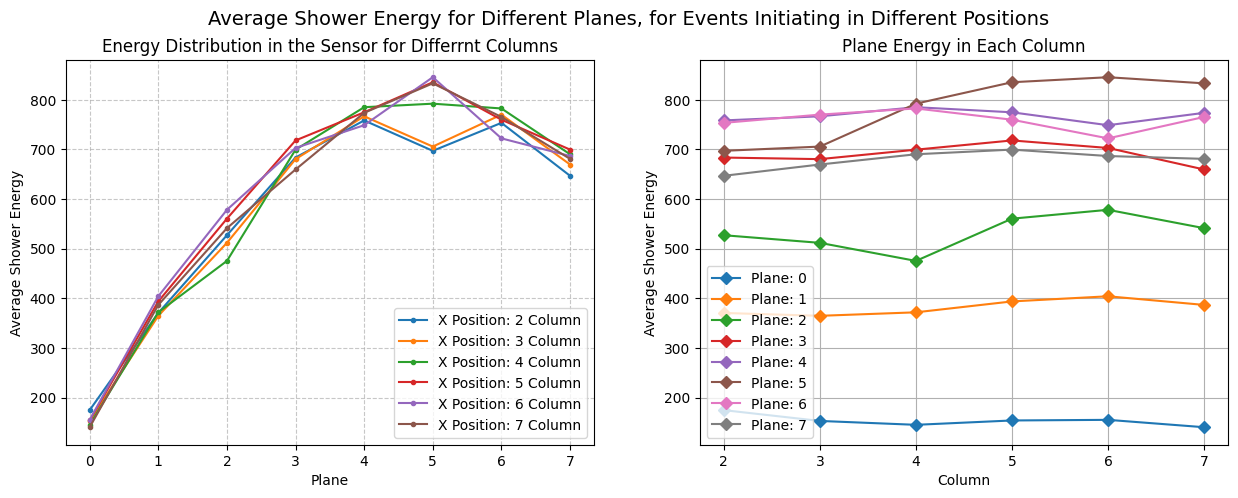

In [5]:
rf.avg_ENERGY_vs_plane_per_X_position(hit_data_1101, 6, print_energies = "true")


In [ ]:
# # returns only the events with one hit on the first plane, with a section of radius from the position in each hit
# def Radii_from_Initial_position(hit_data):
    
#     # reduce data for events starting at 0 plane and acivated one pad only
#     plane_7 = hit_data[hit_data.plane == 7]
#     mask = ak.num(plane_7) == 1
#     first_plane_starting_events = hit_data[mask]

#     # get the initial position for each event
#     x_init, y_init =  rf.initial_X_position_DUT(first_plane_starting_events, return_y = "true")

#     # find the (x,y) ch position for every hit 
#     y_pos, x_pos = divmod(first_plane_starting_events.ch, 20)
    
#     # get the distances from the initial position
#     x_dist = x_pos - x_init
#     y_dist = y_pos - y_init

#     # get the radii
#     radii_squared = x_dist**2 + y_dist**2
#     radii = np.sqrt(radii_squared)

#     # add the radii section to the data
#     events_from_first_plane_with_Radii = ak.with_field(first_plane_starting_events, radii, "Distance")

#     return events_from_first_plane_with_Radii



In [6]:
a = rf.Radii_from_Initial_position(hit_data_1101)

<Array [{plane: 0, ch: 124, ...}, ..., {...}] type='31 * {plane: int32, ch:...'>

In [ ]:
p = 5
plane = a[a.plane == 7 - p]

In [51]:
plane

<Array [[{plane: 2, ch: 84, ...}, ...], ...] type='1086090 * var * {plane: ...'>

In [49]:
Max_Dist = ak.max(plane.Distance, axis=1)
Max_Dist 

<Array [4, 2, 1, 2.24, 2, ..., 3.16, 5.1, 4.47, 2.24] type='1086090 * ?float64'>

In [32]:
max = ak.max(plane.Distance)
max
# np.ceil(max)

np.float64(21.095023109728988)

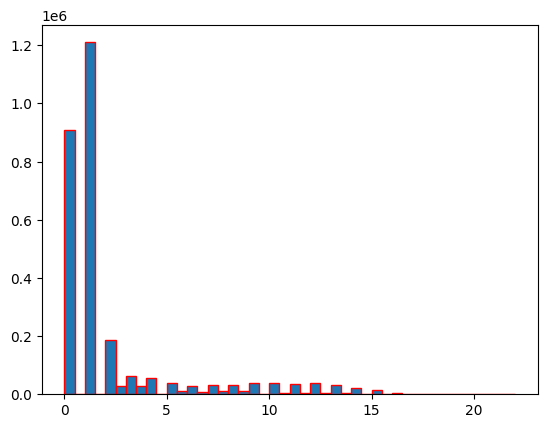

In [38]:
p = 1
plane = a[a.plane == 7 - p]
min = 0
max = np.ceil(ak.max(plane.Distance))
bin_size = 0.5
bins = np.arange(min, max + bin_size, bin_size)
# plt.hist(ak.flatten(plane.Distance), bins = bins, edgecolor = "red")
plt.hist(ak.flatten(plane.Distance), bins = bins, edgecolor = "red")
plt.show()

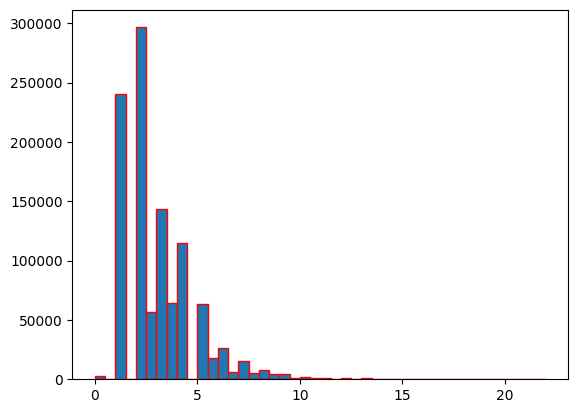

In [50]:
plt.hist(Max_Dist, bins = bins, edgecolor = "red")
plt.show()

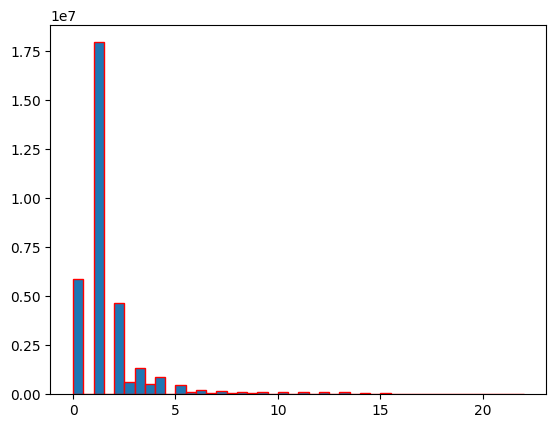

In [37]:
plt.hist(ak.flatten(a.Distance), bins = bins, edgecolor = "red")
plt.show()

In [ ]:
# find the expansion in Pads of the shower in a certain plane

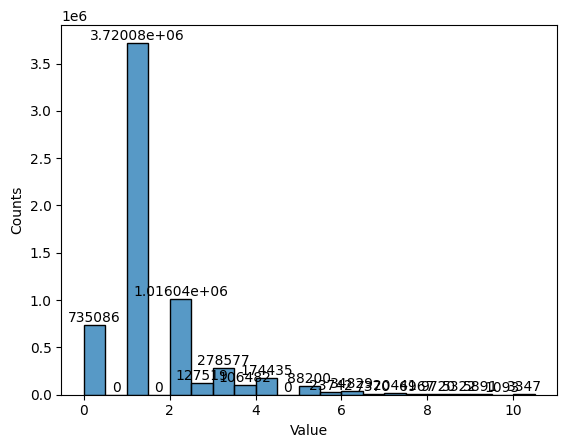

In [45]:
# ax = seaborn.histplot(plane.Distance[3], bins=np.arange(0, 11, 0.5), edgecolor="black")
ax = seaborn.histplot(ak.flatten(plane.Distance), bins=np.arange(0, 11, 0.5), edgecolor="black")

# add counts on top of each bar
ax.bar_label(ax.containers[0])

plt.xlabel("Value")
plt.ylabel("Counts")
plt.show()